# Week 3B: Intro to Geospatial Data Analysis with GeoPandas

- Section 401
- Sep 20, 2023

## Housekeeping

- [Homework #1](https://github.com/MUSA-550-Fall-2023/assignment-1) due on Monday (9/25)
- [Homework #2](https://github.com/MUSA-550-Fall-2023/assignment-2) will be assigned same day
- Choose a dataset to visualize and explore
    - [OpenDataPhilly](https://opendataphilly.org) or one your choosing
    - Email me if you want to analyze one that's not on OpenDataPhilly

## Agenda for today

- Introduction to GeoPandas and vector data
- Spatial relationships and joins

::: {.callout-note}
We'll continue geospatial analysis next week, with:
- Visualization for geospatial data
- Demo: 311 requests by neighborhood in Philadelphia
- Exercise: Property assessments by neighborhood
:::

In [1]:
# Let's setup the imports we'll need first

import altair as alt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

## Part 1: Vector geospatial data in Python


- **Vector** refers to **discrete geometric entities**
- The [Open Geospatial Consortium](https://en.wikipedia.org/wiki/Open_Geospatial_Consortium) has standardized a set of [**simple features**](https://en.wikipedia.org/wiki/Simple_Features)
- Includes points, lines, and polygons

<center>
    <img src="imgs/simple-features.png" width=600></img>
</center>

[Source](https://www.earthdatascience.org/workshops/gis-open-source-python/intro-vector-data-python/)

### A couple of terminology notes

- A **feature** refers to both the geometry and attributes of specific piece of vector data
- A **feature collection** is a list, or collection, of features

Both terms are very common in Python geospatial software.

### Common formats for vector datasets

#### 1. A shapefile

Actually several files with the same common prefix.

Mandatory files: 

- **.shp**: the file containing the geometries
- **.shx**: the file that indexes the geometry
- **.dbf**: tabular data format storing the attributes for each geometry
    
And many optional files for documentation, projection information, etc.

Let's take a look at an example shapefile:

We'll use the `%ls` command to *list* out all of the files in an example shapefile in the `data/` folder

In [2]:
%ls "data/ne_110m_admin_0_countries/"

ne_110m_admin_0_countries.cpg  ne_110m_admin_0_countries.shp
ne_110m_admin_0_countries.dbf  ne_110m_admin_0_countries.shx
ne_110m_admin_0_countries.prj


#### 2. The GeoJSON file

- Stores simple features in a JSON format
- Arose due to the prevalence of the JSON format, especially on the web

::: {.callout-note title="Additional GeoJSON resources"}
- GitHub lets you view GeoJSON files natively. See [Philadelphia ZIP Codes](https://github.com/MUSA-550-Fall-2023/week-3/blob/main/data/Zipcodes_Poly.geojson) in the `data/` folder of this week's repo.
- http://geojson.io provides interactive creation and viewing of small GeoJSON files
:::

### Analyzing vector data with GeoPandas

`geopandas` provides a simple, intuitive for the main types of geospatial vector file formats

![](imgs/geopandas-logo.jpeg){width=600}

In [2]:
# The import statement
import geopandas as gpd

**Example:** Let's load a shape file of countries in the world...

[Source: Natural Earth Data](http://www.naturalearthdata.com/downloads/110m-cultural-vectors/110m-admin-0-countries/)

We can use the [read_file()](https://geopandas.org/docs/reference/api/geopandas.read_file.html) function to read shapefiles and GeoJSON files.

In [3]:
# Read the shape file, giving the name of the directory
countries = gpd.read_file("./data/ne_110m_admin_0_countries")

In [4]:
countries.head()

,iso_a3,name,continent,pop_est,gdp_md_est,geometry
0,AFG,Afghanistan,Asia,34124811.0,64080.0,"POLYGON ((61.21082 35.65007, 62.23065 35.27066..."
1,AGO,Angola,Africa,29310273.0,189000.0,"MULTIPOLYGON (((23.90415 -11.72228, 24.07991 -..."
2,ALB,Albania,Europe,3047987.0,33900.0,"POLYGON ((21.02004 40.84273, 20.99999 40.58000..."
3,ARE,United Arab Emirates,Asia,6072475.0,667200.0,"POLYGON ((51.57952 24.24550, 51.75744 24.29407..."
4,ARG,Argentina,South America,44293293.0,879400.0,"MULTIPOLYGON (((-66.95992 -54.89681, -67.56244..."


In [5]:
type(countries)

geopandas.geodataframe.GeoDataFrame

### What's a `GeoDataFrame`?

Just like a `DataFrame` but with a new, special `geometry` column:

<img src="imgs/geodataframe.svg"/>

Print out the first 10 entires of the "geometry" column:

In [6]:
countries["geometry"].head(n=10)

0    POLYGON ((61.21082 35.65007, 62.23065 35.27066...
1    MULTIPOLYGON (((23.90415 -11.72228, 24.07991 -...
2    POLYGON ((21.02004 40.84273, 20.99999 40.58000...
3    POLYGON ((51.57952 24.24550, 51.75744 24.29407...
4    MULTIPOLYGON (((-66.95992 -54.89681, -67.56244...
5    POLYGON ((43.58275 41.09214, 44.97248 41.24813...
6    MULTIPOLYGON (((-59.57209 -80.04018, -59.86585...
7    POLYGON ((68.93500 -48.62500, 69.58000 -48.940...
8    MULTIPOLYGON (((145.39798 -40.79255, 146.36412...
9    POLYGON ((16.97967 48.12350, 16.90375 47.71487...
Name: geometry, dtype: geometry

Take a look at the first geometry polygon by using the `.iloc[]` selector:

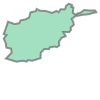

In [11]:
countries.geometry.iloc[0]

### We can still leverage the power of `pandas`...

Calculate the total world population:

In [12]:
countries["pop_est"].sum() / 1e9  # In billions

7.383089462

Calculate the total population on each continent:

In [13]:
grouped = countries.groupby("continent")

grouped

::: {.callout-note title="Remember"}

The `groupby()` function does not return a `DataFrame` — you need to call `sum()`, `mean()` etc, or `apply()` a function to get your desired result!

:::

Access the "pop_est" column from the groupby variable ("grouped") and then call the `.sum()` function to calculate our desired statistic:

In [14]:
pop_by_continent = grouped["pop_est"].sum()

pop_by_continent

continent
Africa                     1.219176e+09
Antarctica                 4.050000e+03
Asia                       4.389145e+09
Europe                     7.463985e+08
North America              5.730421e+08
Oceania                    3.678284e+07
Seven seas (open ocean)    1.400000e+02
South America              4.185407e+08
Name: pop_est, dtype: float64

In [12]:
# Sort values
pop_by_continent.sort_values(ascending=False, inplace=True)

# Output sorted values from cell
pop_by_continent / 1e9

continent
Asia                       4.389145e+00
Africa                     1.219176e+00
Europe                     7.463985e-01
North America              5.730421e-01
South America              4.185407e-01
Oceania                    3.678284e-02
Antarctica                 4.050000e-06
Seven seas (open ocean)    1.400000e-07
Name: pop_est, dtype: float64

Filter the data frame based on a boolean selection:

In [15]:
# Is the country name USA?
is_USA = countries["name"] == "United States of America"

# Get the row with USA
USA = countries.loc[is_USA]

USA

,iso_a3,name,continent,pop_est,gdp_md_est,geometry
168,USA,United States of America,North America,326625791.0,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


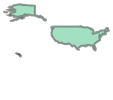

In [16]:
USA.squeeze().geometry

::: {.callout-note title="Reminder: the squeeze() function"}

The `squeeze()` function does just one it sounds like: if you have a DataFrame with only one row, it will "squeeze" the row dimension by removing it, returning just a Series object:

:::

In [17]:
# Squeeze
USA = USA.squeeze()

# Print out the types
print("The type of USA is: ", type(USA))

# Output
USA

The type of USA is:  <class 'pandas.core.series.Series'>


iso_a3                                                      USA
name                                   United States of America
continent                                         North America
pop_est                                             326625791.0
gdp_md_est                                           18560000.0
geometry      MULTIPOLYGON (((-122.84000000000005 49.0000000...
Name: 168, dtype: object

The simple features (Lines, Points, Polygons) are implemented by the [shapely](https://shapely.readthedocs.io/en/stable/manual.html) library

In [18]:
type(USA.geometry)

shapely.geometry.multipolygon.MultiPolygon

JupyterLab renders `shapely` geometries automatically:

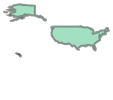

In [19]:
# a mini USA
USA.geometry

### How does `geopandas` handle coordinate systems and map projections?

A **coordinate reference system** (CRS) relates the position of a geometry object on the spherical earth to its two-dimensional coordinates.

A `GeoDataFrame` or `GeoSeries` has a `.crs` attribute which specifies the coordinate reference system.

In [20]:
countries.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### The EPSG=4326 CRS

- EPSG 4326 is known as WGS 84 where `x` and `y` are longitude and latitude. 
- It is is the default coordinate system for GPS systems.
- It's also known as *Plate Carrée* or *equirectangular*

### How to plot all of the geometries at once?

Use the `plot()` function to get a quick and dirty plot of all of the geometry features.

**Note:** the `plot()` returns the current maplotlib axes, allowing you to format the chart after plotting.

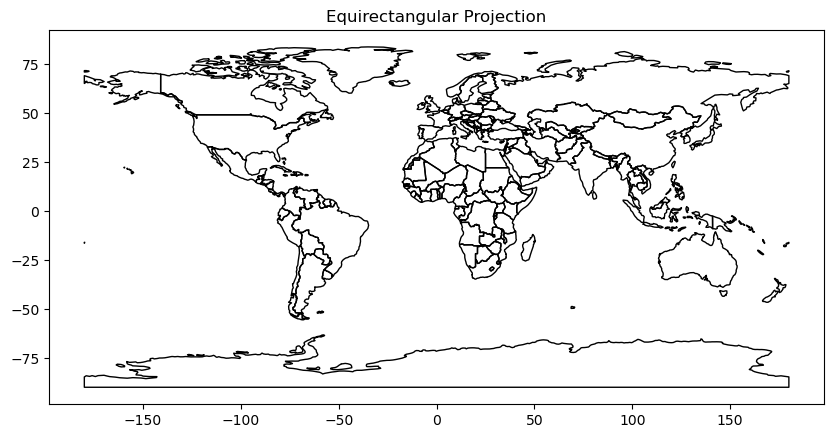

In [24]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the countries on our axes
ax = countries.plot(ax=ax, facecolor="none", edgecolor="black")

# Add a title
ax.set_title("Equirectangular Projection");

<center>
    <img src="imgs/equirectangular.png" width="800"/>
</center>

### Can we convert to other coordinate systems?

Use the `df.to_crs()` function! The most well-known projections can be specified by their EPSG code.

Geopandas documentation on re-projecting: [Managing Projections](https://geopandas.org/projections.html#re-projecting)

#### Let's convert to the Mercator projection

[EPSG code: 3395](http://spatialreference.org/ref/epsg/wgs-84-world-mercator/)

In [31]:
# Remove Antartica, as the Mercator projection
# cannot deal with the poles
no_antarctica = countries.loc[(countries["name"] != "Antarctica")]

In [32]:
# Two ways to specify the EPSG code
countries_mercator = no_antartica.to_crs(epsg=3395)

# Alternatively:
# countries_mercator = no_antartica.to_crs("EPSG:3395")

In [33]:
countries_mercator.head()

,iso_a3,name,continent,pop_est,gdp_md_est,geometry
0,AFG,Afghanistan,Asia,34124811.0,64080.0,"POLYGON ((6813956.990 4227673.562, 6927484.435..."
1,AGO,Angola,Africa,29310273.0,189000.0,"MULTIPOLYGON (((2660998.216 -1305442.810, 2680..."
2,ALB,Albania,Europe,3047987.0,33900.0,"POLYGON ((2339940.185 4961221.199, 2337708.178..."
3,ARE,United Arab Emirates,Asia,6072475.0,667200.0,"POLYGON ((5741805.754 2765811.385, 5761611.935..."
4,ARG,Argentina,South America,44293293.0,879400.0,"MULTIPOLYGON (((-7453944.198 -7306880.704, -75..."


::: {.callout-tip }
Take a look at the values in the "geometry" column above. The magnitude of the coordinates changed! This is a quick and easy way to tell if the re-projection worked properly!
:::

#### Now let's plot it!

The easy way...with geopandas built-in `plot()` function

Text(0.5, 1.0, 'Mercator Projection')

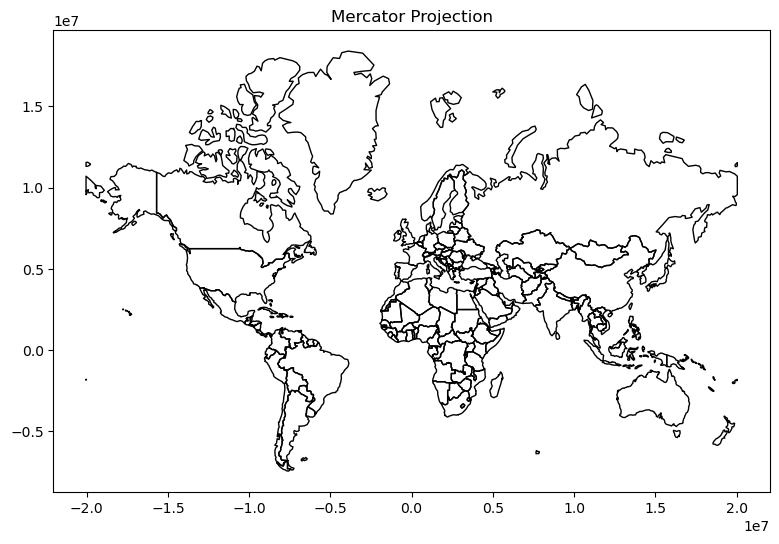

In [35]:
# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Use built-in plot() of the GeoDataFrame
ax = countries_mercator.plot(ax=ax, facecolor="none", edgecolor="black")

# Add a title
ax.set_title("Mercator Projection")

<center>
    <img src="imgs/mercator.png" width="800"/>
</center>

#### Which one is your favorite?


![](https://imgs.xkcd.com/comics/map_projections.png)

[Source: xkcd](https://xkcd.com/977/)

::: {.callout-tip title="Tip: Choosing the right CRS"}

- For city-based data, the Web Mercator CRS ([EPSG=3857](https://epsg.io/3857)) is best. This CRS became popular after Google Maps adopted it.
- You can also use a CRS specific to individual states, e.g., the [PA State Plane EPSG=2272](https://epsg.io/2272) is a good option for Philadelphia
:::

### Let's load the city limits for Philadelphia

We'll use the provided `City_Limits` shape file in the `data/` folder

In [36]:
city_limits = gpd.read_file("./data/City_Limits")

city_limits

,OBJECTID,Shape__Are,Shape__Len,geometry
0,1,0.038911,1.259687,"POLYGON ((-75.01497 40.13793, -75.01456 40.137..."


#### What's the CRS?

Use the `.crs` attribute to find out!

In [37]:
city_limits.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Plot it with the EPSG=4326 CRS:

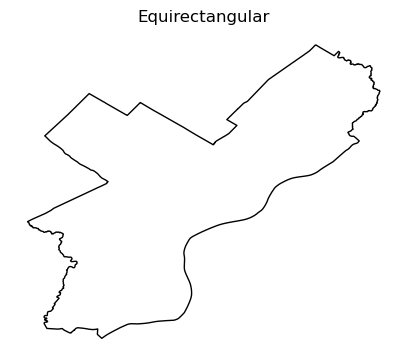

In [38]:
# Create our figure and axes
fig, ax = plt.subplots(figsize=(5, 5))

# Plot
city_limits.plot(ax=ax, facecolor="none", edgecolor="black")

# Format
ax.set_title("Equirectangular")
ax.set_axis_off()  # This will remove the axes completely
ax.set_aspect("equal")  # This forces an equal aspect ratio

This is *not* what Philadelphia looks like..

Let's try EPSG=3857 instead:

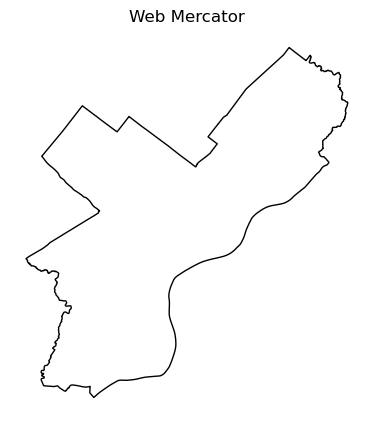

In [39]:
# Create the figure
fig, ax = plt.subplots(figsize=(5, 5))

# Convert to EPSG:3857
city_limits_3857 = city_limits.to_crs(epsg=3857)

# Plot and format
city_limits_3857.plot(ax=ax, facecolor="none", edgecolor="black")

ax.set_title("Web Mercator")
ax.set_axis_off()
ax.set_aspect("equal");

::: {.callout-warning title="Important"}

The equirectangular CRS (EPSG=4326) is often used by default and will make cities appear wider and flatter than they really are.

:::

#### Saving GeoDataFrames


Use the `to_file()` function and specify the driver.

In [40]:
# ESRI shape file
city_limits_3857.to_file("./data/city_limits_3857", driver="Shapefile")

In [42]:
# GeoJSON is also an option
city_limits_3857.to_file("./data/city_limits_3857.geojson", driver="GeoJSON")

#### How about as a CSV file?

Yes, but reading requires more work...

In [44]:
# save a csv file
city_limits_3857.to_csv("./data/city_limits_3857.csv", index=False)

In [45]:
df = pd.read_csv("./data/city_limits_3857.csv")
df.head()

,OBJECTID,Shape__Are,Shape__Len,geometry
0,1,0.038911,1.259687,"POLYGON ((-8350627.97509646 4886006.88680784, ..."


#### Looks similar...

**But,** the "geometry" column is just stored as a string...it's not a shapely Polygon

In [46]:
type(df.geometry)

pandas.core.series.Series

#### Use `shapely` to parse the string version of the polygons

In [47]:
from shapely import wkt

# wkt.loads will convert from string to Polygon object
df["geometry"] = df["geometry"].apply(wkt.loads)

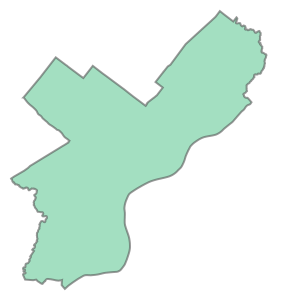

In [48]:
df.geometry.iloc[0]

Success!

#### Converting from a DataFrame to a GeoDataFrame

We can initialize the GeoDataFrame directly from a DataFrame but we need to specify **two things**:

1. The name of the "geometry" column 
2. The CRS of the "geometry" column

::: {.callout-warning title="Watch out!"}

The CRS that you specify when you create the GeoDataFrame must match the CRS of the data. It is **not** the CRS that you wish the data was in. If you would like to convert to a different CRS, you'll need to call the `.to_crs()` after creating your GeoDataFrame.

:::

In this case, the geometry column was saved in Web Mercator EPSG=3857

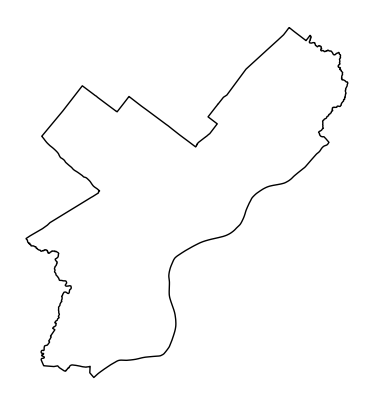

In [51]:
# Make specifying the name of the geometry column and CRS
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:3857")

# Now plot
fig, ax = plt.subplots(figsize=(5, 5))
ax = gdf.plot(ax=ax, facecolor="none", edgecolor="black")
ax.set_axis_off()
ax.set_aspect("equal")

#### Let's convert back to 4326 and plot 

The tilt should be a bit more obvious now...

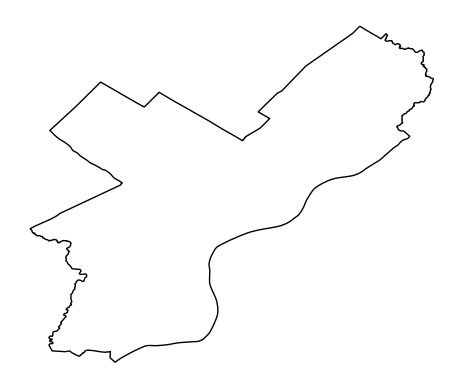

In [52]:
ax = gdf.to_crs(epsg=4326).plot(facecolor="none", edgecolor="black")

ax.set_axis_off()
ax.set_aspect("equal")

::: {.callout-note}

- I didn't use `plt.subplots()` here to create a figure/axes – I let geopandas automatically make one
- I've chained together the `to_crs()` and `.plot()` functions in one line
- The `.plot()` function returns the axes object that geopandas used to plot — this lets you customizes the axes after plotting

:::

### So, when should you use GeoPandas?

- For exploratory data analysis and visualization, including in Jupyter notebooks
- Pre-processing data to be fed into a desktop GIS program
- For compact, readable, and reproducible code
- If you’re comfortable with Pandas and/or R data frames.

### When it may not be the best tool:

- For polished multilayer map creation — one option is to use a desktop GIS like QGIS.
- If you need very high performance — geopandas can be slow compared to other GIS software.

## Part 2: Spatial Relationships and Joins

Let's explore joins and merges between GeoDataFrames based on geospatial relationships...

In [54]:
# Load some cities data from the data/ folder
cities = gpd.read_file("./data/ne_110m_populated_places")

In [55]:
cities

,name,geometry
0,Vatican City,POINT (12.45339 41.90328)
1,San Marino,POINT (12.44177 43.93610)
2,Vaduz,POINT (9.51667 47.13372)
3,Lobamba,POINT (31.20000 -26.46667)
4,Luxembourg,POINT (6.13000 49.61166)
...,...,...
238,Rio de Janeiro,POINT (-43.22697 -22.92308)
239,São Paulo,POINT (-46.62697 -23.55673)
240,Sydney,POINT (151.18323 -33.91807)
241,Singapore,POINT (103.85387 1.29498)


<center>
    <img src="imgs/spatial-relationships.png" width=600></img>
</center>

(Image by [Krauss, CC BY-SA 3.0](https://en.wikipedia.org/wiki/Spatial_relation#/media/File:TopologicSpatialRelarions2.png))

All of these operations are available as functions of a `GeoDataFrame`.

### A quick example

What country is New York in?

**Spoiler**: the USA

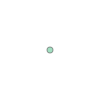

In [56]:
# Select the Point representing New York City
new_york = cities.loc[cities["name"] == "New York"].geometry.squeeze()
new_york

In [57]:
type(new_york)

shapely.geometry.point.Point

In [58]:
countries.contains(new_york)

0      False
1      False
2      False
3      False
4      False
       ...  
172    False
173    False
174    False
175    False
176    False
Length: 177, dtype: bool

In [59]:
# Find the country that contains New York
countries.loc[countries.contains(new_york)]

,iso_a3,name,continent,pop_est,gdp_md_est,geometry
168,USA,United States of America,North America,326625791.0,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


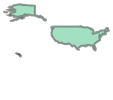

In [60]:
# Get the geometry column of the country containing NYC
USA = countries.loc[countries.contains(new_york)].squeeze().geometry
USA

::: {.callout-note}

The `.loc[]` function can take the index selector as the first argument, and the name of a column as a second argument (separated by a comma)

:::

In [61]:
type(USA)

shapely.geometry.multipolygon.MultiPolygon

In [62]:
# Is New York within the USA?
new_york.within(USA)

True

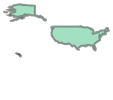

In [63]:
USA

### References

The different functions for checking spatial relationships:

- `equals`
- `contains`
- `crosses`
- `disjoint`
- `intersects`
- `overlaps`
- `touches`
- `within`
- `covers`

See [the shapely documentation](https://shapely.readthedocs.io/en/stable/manual.html#predicates-and-relationships) for an overview of these methods.

### 1. The spatial join: `sjoin()`


**SPATIAL JOIN** = merging attributes from two geometry layers based on their spatial relationship

Different parts of this operations:

- The GeoDataFrame to which we want add information
- The GeoDataFrame that contains the information we want to add
- The spatial relationship we want to use to match both datasets (**intersects**, **contains**, **within**)
- The type of join: **left** or **inner** join

In this case, we want to join the `cities` dataframe, containing `Point` geometries, with the information of the `countries` dataframe, containing `Polygon` geometries.

To match cities with countries, we'll use the `within` spatial relationship.

The [`geopandas.sjoin()`](https://geopandas.org/reference/geopandas.sjoin.html) function performs this operation:

In [69]:
joined = gpd.sjoin(cities, countries, predicate="within", how="left")

In [70]:
joined.head()

,name_left,geometry,index_right,iso_a3,name_right,continent,pop_est,gdp_md_est
0,Vatican City,POINT (12.45339 41.90328),79.0,ITA,Italy,Europe,62137802.0,2221000.0
1,San Marino,POINT (12.44177 43.93610),79.0,ITA,Italy,Europe,62137802.0,2221000.0
2,Vaduz,POINT (9.51667 47.13372),9.0,AUT,Austria,Europe,8754413.0,416600.0
3,Lobamba,POINT (31.20000 -26.46667),152.0,SWZ,Swaziland,Africa,1467152.0,11060.0
4,Luxembourg,POINT (6.13000 49.61166),97.0,LUX,Luxembourg,Europe,594130.0,58740.0


As we can see above, the attributes of the cities (left) and countries (right) have been merged based on whether the city is inside the country.

Let's select cities in Italy only:

In [71]:
cities_in_italy = joined.loc[joined["name_right"] == "Italy"]
cities_in_italy

,name_left,geometry,index_right,iso_a3,name_right,continent,pop_est,gdp_md_est
0,Vatican City,POINT (12.45339 41.90328),79.0,ITA,Italy,Europe,62137802.0,2221000.0
1,San Marino,POINT (12.44177 43.93610),79.0,ITA,Italy,Europe,62137802.0,2221000.0
226,Rome,POINT (12.48131 41.89790),79.0,ITA,Italy,Europe,62137802.0,2221000.0


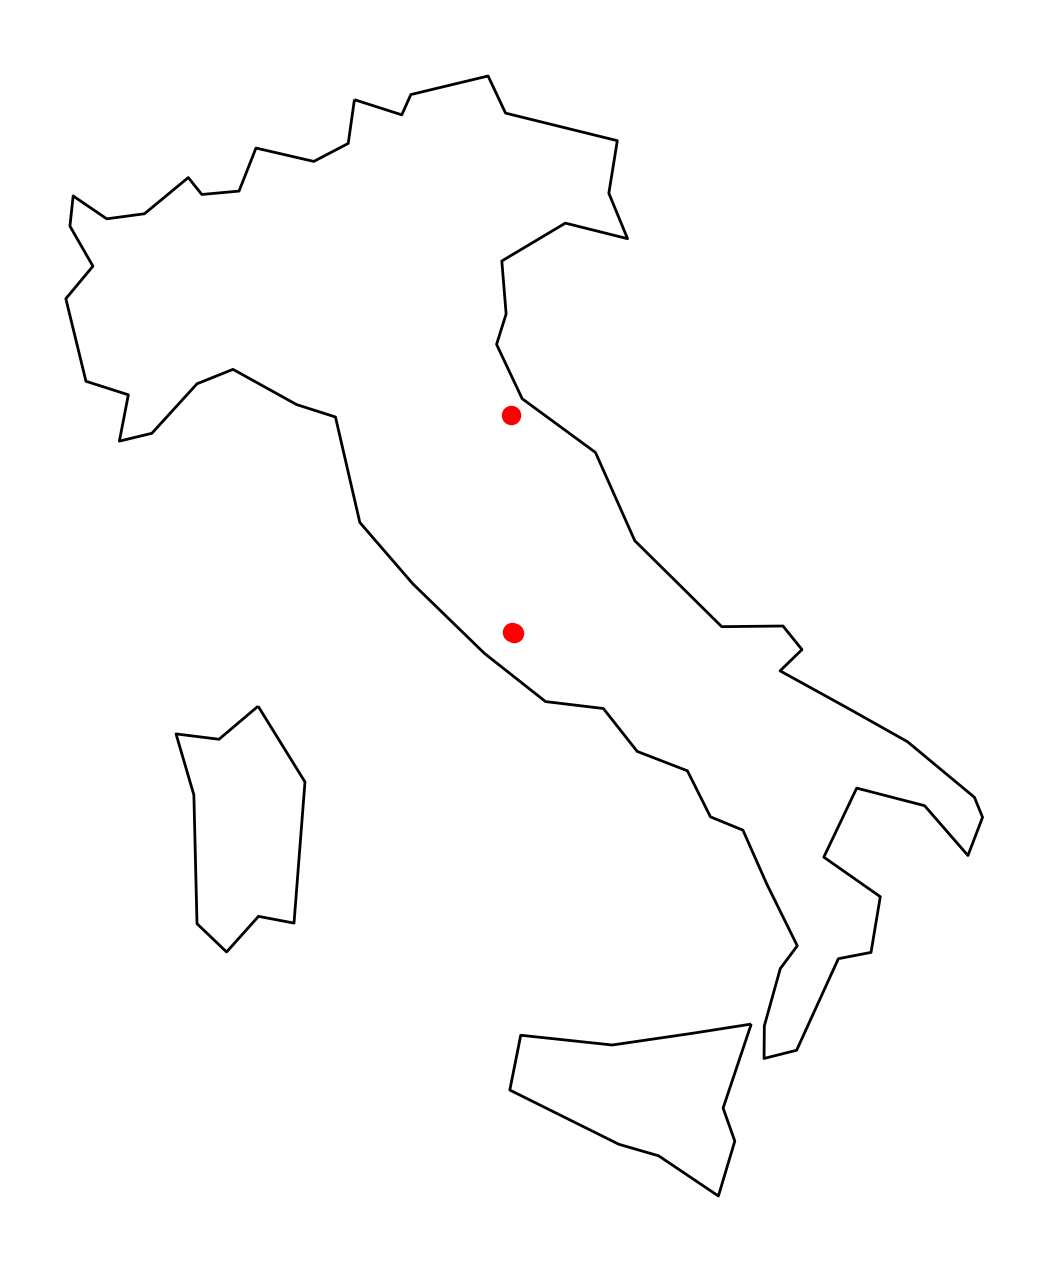

In [50]:
# Extract Italy
italy = countries.loc[countries["name"] == "Italy"]

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
italy.plot(ax=ax, facecolor="none", edgecolor="black")
ax.set_axis_off()
ax.set_aspect("equal")

# Plot the first city in the joined data frame (Vatican City)
# Use the same axes by passing in the ax=ax keyword
ax = cities_in_italy.plot(ax=ax, color="red")

### 2. Spatial overlay operation: `overlay()`

We can also perform the "join" operation on the **geometries** rather than just combining **attributes**.

The `overlay()` function combines geometries, e.g. by taking the intersection of the geometries.

Select all countries in Africa:

In [72]:
africa = countries.loc[countries["continent"] == "Africa"]

In [73]:
africa.head()

,iso_a3,name,continent,pop_est,gdp_md_est,geometry
1,AGO,Angola,Africa,29310273.0,189000.0,"MULTIPOLYGON (((23.90415 -11.72228, 24.07991 -..."
11,BDI,Burundi,Africa,11466756.0,7892.0,"POLYGON ((29.34000 -4.49998, 29.27638 -3.29391..."
13,BEN,Benin,Africa,11038805.0,24310.0,"POLYGON ((2.69170 6.25882, 1.86524 6.14216, 1...."
14,BFA,Burkina Faso,Africa,20107509.0,32990.0,"POLYGON ((2.15447 11.94015, 1.93599 11.64115, ..."
25,BWA,Botswana,Africa,2214858.0,35900.0,"POLYGON ((29.43219 -22.09131, 28.01724 -22.827..."


What is the CRS?

In [74]:
africa.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [77]:
# Let's transform to a CRS that uses meters
# instead of degrees (EPSG=3857)
africa = africa.to_crs(epsg=3857)

africa.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Plot it:

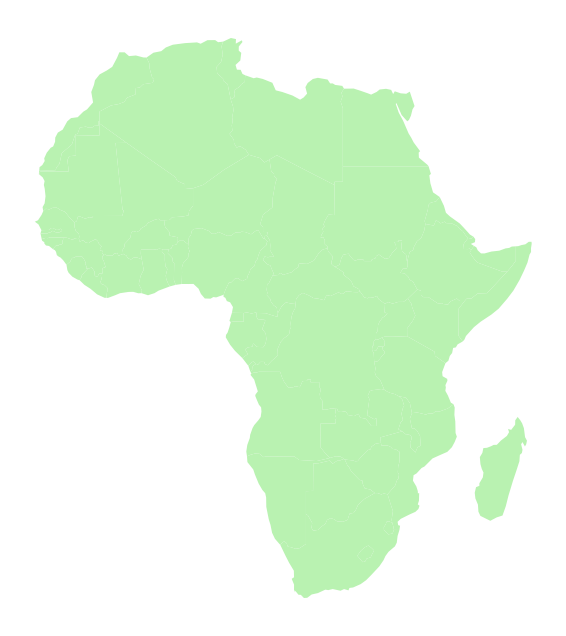

In [78]:
fig, ax = plt.subplots(figsize=(8, 8))

africa.plot(ax=ax, facecolor="#b9f2b1")

ax.set_axis_off()
ax.set_aspect("equal")

In [80]:
# Important CRS needs to match!
cities_3857 = cities.to_crs(epsg=3857)

In [81]:
# Create a copy of the GeoDataFrame
buffered_cities = cities_3857.copy()

# Add a buffer region of 250 km around all cities
buffered_cities["geometry"] = buffered_cities.buffer(250e3)

#### Plot the difference of the two geometries

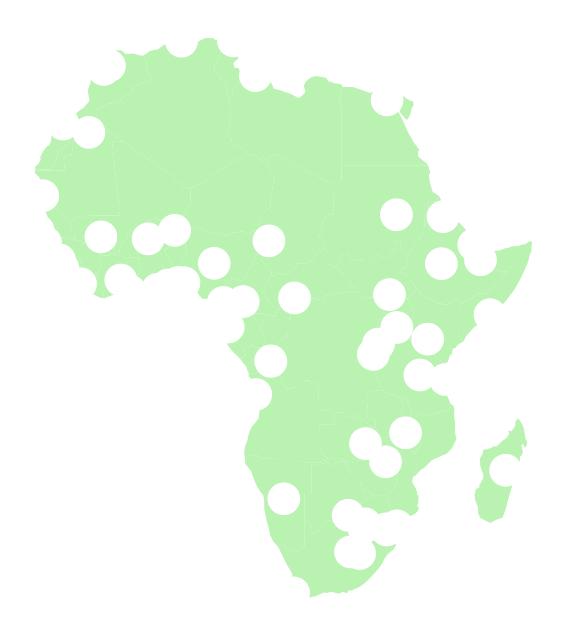

In [82]:
fig, ax = plt.subplots(figsize=(8, 8))

# Calculate the difference of the geometry sets
diff = gpd.overlay(
    africa,
    buffered_cities,
    how="difference",
)

# Plot
diff.plot(facecolor="#b9f2b1", ax=ax)
ax.set_axis_off()
ax.set_aspect("equal")

In [59]:
# Data attributes are the same as the first data frame (africa)
# with an updated geometry column
diff.head()

,iso_a3,name,continent,pop_est,gdp_md_est,geometry
0,AGO,Angola,Africa,29310273.0,189000.0,"MULTIPOLYGON (((2673464.087 -1449571.330, 2441..."
1,BEN,Benin,Africa,11038805.0,24310.0,"POLYGON ((100138.898 1231805.081, 138422.412 1..."
2,BFA,Burkina Faso,Africa,20107509.0,32990.0,"MULTIPOLYGON (((100138.898 1231805.081, 26368...."
3,BWA,Botswana,Africa,2214858.0,35900.0,"POLYGON ((3065120.801 -2659823.621, 3061281.52..."
4,CAF,Central African Rep.,Africa,5625118.0,3206.0,"POLYGON ((1792937.514 836963.765, 1813457.017 ..."


#### Plot the intersection of the two geometries

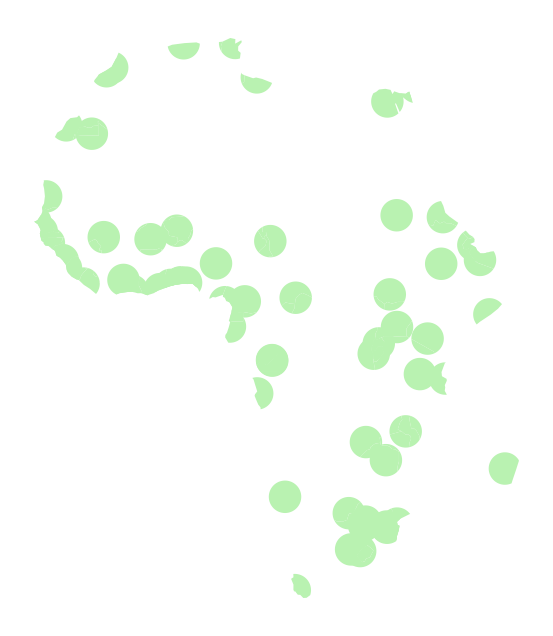

In [83]:
fig, ax = plt.subplots(figsize=(8, 8))

# The intersection of the geometry sets
intersection = gpd.overlay(africa, buffered_cities, how="intersection")

# Plot
intersection.plot(ax=ax, facecolor="#b9f2b1")
ax.set_axis_off()
ax.set_aspect("equal")

### Recap: spatial operations

- **Spatial join**: merge attributes from one data frame to another based on the spatial relationship
- **Spatial overlay**: creating new geometries based on spatial operation between both data frames (and not combining attributes of both data frames)

## Example: Exploring trash-related 311 tickets by neighborhood in 2020

Let's test out our geospatial skills by exploring data for 311 requests in Philadelphia during the pandemic in 2020. We'll get started by summarizing the data by month and then dive into examining trends by neighborhood.


::: {.callout-tip title="Find out more..."}

Trash collection was a big concern in Philadelphia when the pandemic began.
Check out [this article](https://www.inquirer.com/news/philadephia-trash-recycling-collection-delays-covid-20200806.html) in the Philadelphia Inquirer for more details!

:::



First, let's load our data from the `data/` folder. I downloaded the data from [OpenDataPhilly](https://www.opendataphilly.org/dataset/311-service-and-information-requests) for tickets from 2020 and trimmed to those requests that have been categorized as "Rubbish/Recyclable Material Collection". These are tickets related to missed trash pickup by the City's Streets Department.

In [87]:
# Load the data from a CSV file into a pandas DataFrame
trash_requests_df = pd.read_csv(
    "data/trash_311_requests_2020.csv",  # Use the file path relative to the current folder
)

In [85]:
print("number of requests = ", len(trash_requests_df))

number of requests =  47730


In [86]:
trash_requests_df.head()

,objectid,service_request_id,status,status_notes,service_name,service_code,agency_responsible,service_notice,requested_datetime,updated_datetime,expected_datetime,address,zipcode,media_url,lat,lon
0,8180042,13269656,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-04-02 19:22:24,2020-04-06 07:02:57,2020-04-06 20:00:00,624 FOULKROD ST,NaN,NaN,40.034389,-75.106518
1,8180043,13266979,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-04-02 08:40:53,2020-04-06 07:02:58,2020-04-05 20:00:00,1203 ELLSWORTH ST,NaN,NaN,39.936164,-75.163497
2,7744426,13066443,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-02 19:17:55,2020-01-04 05:46:06,2020-01-06 19:00:00,9054 WESLEYAN RD,NaN,NaN,40.058737,-75.018345
3,7744427,13066540,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-03 07:01:46,2020-01-04 05:46:07,2020-01-06 19:00:00,2784 WILLITS RD,NaN,NaN,40.063658,-75.022347
4,7801094,13089345,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-15 13:22:14,2020-01-16 14:03:29,2020-01-16 19:00:00,6137 LOCUST ST,NaN,NaN,39.958186,-75.244732


### First, convert to a GeoDataFrame

Remove the requests missing lat/lon coordinates

In [88]:
trash_requests_df = trash_requests_df.dropna(subset=["lat", "lon"])

Create Point objects for each `lat` and `lon` combination.

We can use the helper utility function: [`geopandas.points_from_xy()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.points_from_xy.html)

In [89]:
trash_requests_df["geometry"] = gpd.points_from_xy(
    trash_requests_df["lon"], trash_requests_df["lat"]
)

In [66]:
trash_requests_df["geometry"].head()

0    POINT (-75.10652 40.03439)
1    POINT (-75.16350 39.93616)
2    POINT (-75.01835 40.05874)
3    POINT (-75.02235 40.06366)
4    POINT (-75.24473 39.95819)
Name: geometry, dtype: geometry

Now, let's create our GeoDataFrame object.


::: {.callout-warning title="Important"}

- Don't forget to set the CRS manually! 
- The CRS you specify when creating a GeoDataFrame should tell geopandas what the coordinate system the input data is in.
- Usually you will be reading lat/lng coordinates, and will need to specify the crs as EPSG code 4326
- You should specify the crs as a string using the syntax: `ESPG:4326`

:::


Since we're only using a few EPSG codes in this course, you can usually tell what the CRS is by looking at the values in the Point() objects.

Philadelphia has a latitude of about 40 deg and longitude of about -75 deg.

**Our data must be in the usual lat/lng EPSG=4326!**

![](imgs/lat-lng-point-example.png)

Finally, let's create our GeoDataFrame:

In [90]:
trash_requests_gdf = gpd.GeoDataFrame(
    trash_requests_df, geometry="geometry", crs="EPSG:4326"
)

### Let's plot the monthly trash requests

Let's add some new columns based on the "requested_datetime". Right now, this column is a string, denoted by the dtype "object" in pandas language:

In [91]:
trash_requests_gdf["requested_datetime"].head()

0    2020-04-02 19:22:24
1    2020-04-02 08:40:53
2    2020-01-02 19:17:55
3    2020-01-03 07:01:46
4    2020-01-15 13:22:14
Name: requested_datetime, dtype: object

We can now use the `pd.to_datetime()` function to convert to a column of special `Datetime` objects, which have all sorts of useful functionality. 

In [92]:
# Convert the requested datetime to a column of Datetime objects
trash_requests_gdf["requested_datetime_dt"] = pd.to_datetime(
    trash_requests_gdf["requested_datetime"]
)

In [93]:
trash_requests_gdf["requested_datetime_dt"].head()

0   2020-04-02 19:22:24
1   2020-04-02 08:40:53
2   2020-01-02 19:17:55
3   2020-01-03 07:01:46
4   2020-01-15 13:22:14
Name: requested_datetime_dt, dtype: datetime64[ns]

<br/> 

It looks like it worked! We have a "datetime64[ns]" dtype for our new column now.

Now that the column is a `Datetime` Series, it has a special ".dt" attribute. This attribute allows you to quickly extract out parts of the date, e.g., month, day, year, etc., as new columns.

For all of the possible options, see the [API docs for pd.Series](https://pandas.pydata.org/pandas-docs/stable/reference/series.html) — take a look at all of the entries that start with `pd.Series.dt`.

::: {.callout-tip title="Tip: The strftime() function"}

For converting datetime objects to strings in a certain format, we can use the "strftime" function ([docs](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.strftime.html)). This uses a special syntax to convert the date object to a string with a specific format.

**Helpful reference**: Use [this strftime guide](https://strftime.org/) to look up the syntax!

:::

In [96]:
# Use the .dt attribute to extract out the month integer (starting at 0)
trash_requests_gdf["month_int"] = trash_requests_gdf["requested_datetime_dt"].dt.month

# Get the month name too — this is what %B means - (use strftime.org to see the codes!)
trash_requests_gdf["month"] = trash_requests_gdf["requested_datetime_dt"].dt.strftime(
    "%B"
)

In [97]:
trash_requests_gdf.head()

,objectid,service_request_id,status,status_notes,service_name,service_code,agency_responsible,service_notice,requested_datetime,updated_datetime,expected_datetime,address,zipcode,media_url,lat,lon,geometry,requested_datetime_dt,month_int,month
0,8180042,13269656,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-04-02 19:22:24,2020-04-06 07:02:57,2020-04-06 20:00:00,624 FOULKROD ST,NaN,NaN,40.034389,-75.106518,POINT (-75.10652 40.03439),2020-04-02 19:22:24,4,April
1,8180043,13266979,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-04-02 08:40:53,2020-04-06 07:02:58,2020-04-05 20:00:00,1203 ELLSWORTH ST,NaN,NaN,39.936164,-75.163497,POINT (-75.16350 39.93616),2020-04-02 08:40:53,4,April
2,7744426,13066443,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-02 19:17:55,2020-01-04 05:46:06,2020-01-06 19:00:00,9054 WESLEYAN RD,NaN,NaN,40.058737,-75.018345,POINT (-75.01835 40.05874),2020-01-02 19:17:55,1,January
3,7744427,13066540,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-03 07:01:46,2020-01-04 05:46:07,2020-01-06 19:00:00,2784 WILLITS RD,NaN,NaN,40.063658,-75.022347,POINT (-75.02235 40.06366),2020-01-03 07:01:46,1,January
4,7801094,13089345,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-15 13:22:14,2020-01-16 14:03:29,2020-01-16 19:00:00,6137 LOCUST ST,NaN,NaN,39.958186,-75.244732,POINT (-75.24473 39.95819),2020-01-15 13:22:14,1,January


Now, let's group by the month integer and month name, and get the size of the groups using the built-in `.size()` function of the groupby object:

In [98]:
totals_by_month = trash_requests_gdf.groupby(
    by=["month_int", "month"], as_index=False
).size()

totals_by_month

,month_int,month,size
0,1,January,2710
1,2,February,2067
2,3,March,2460
3,4,April,5778
4,5,May,6572
5,6,June,6485
6,7,July,9627
7,8,August,4466
8,9,September,1704
9,10,October,1335


::: {.callout-note}

I've used the `as_index=False` keyword to the `groupby()` function. This will force the `size()` function to return a DataFrame instead of having the `month` column as the index of the resulted groupby operation.

Remember, the columns you group by become the index of the aggregated DataFrame. I often like to have them as columns in the DataFrame instead — the `as_index=False` flag exists for exactly this problem.
:::

### Plot a bar chart with seaborn

For making static bar charts with Python, seaborn's [`sns.barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) is usually the best option!

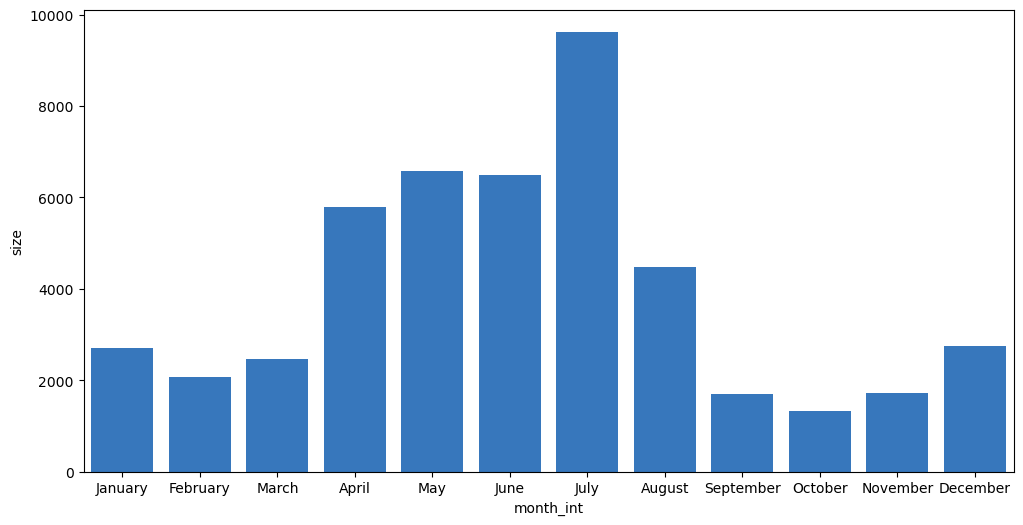

In [99]:
# Initialize figure/axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot!
sns.barplot(
    x="month_int",
    y="size",
    data=totals_by_month,
    color="#2176d2",
    ax=ax,
)

ax.set_xticklabels(totals_by_month["month"]);

### Reference: Let's improve the aesthetics via matplotlib

The trend is clear in the previous chart, but can we do a better job with the aesthetics? Yes!

For reference, here is a common way to clean up charts in matplotlib:

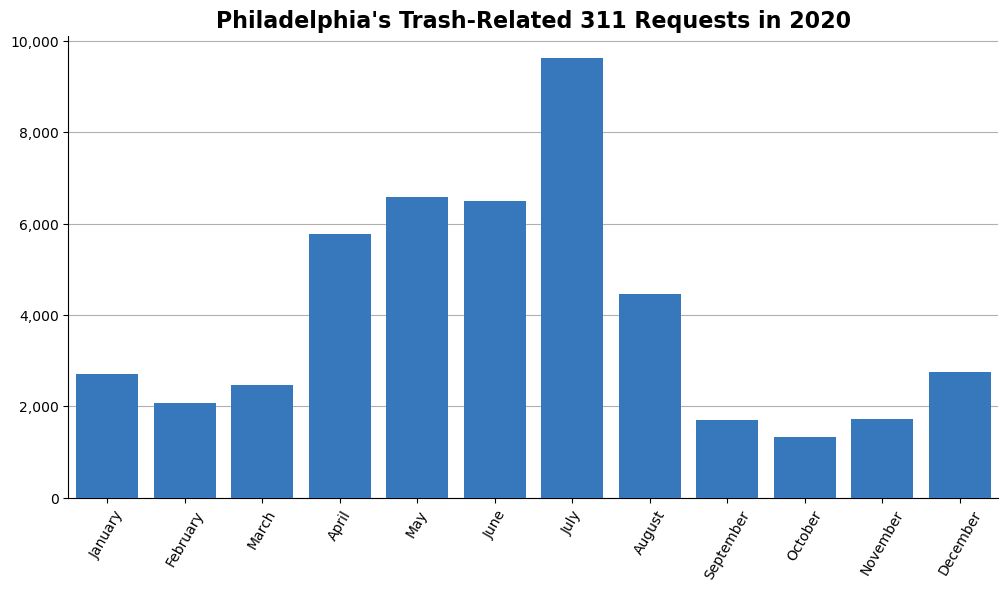

In [100]:
# Initialize figure/axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot!
sns.barplot(
    x="month",
    y="size",
    data=totals_by_month,
    color="#2176d2",
    ax=ax,
    order=[
        "January",
        "February",
        "March",
        "April",
        "May",
        "June",
        "July",
        "August",
        "September",
        "October",
        "November",
        "December",
    ],
    zorder=999,  # Make sure the bar charts are on top of the grid
)

# Remove x/y axis labels
ax.set_xlabel("")
ax.set_ylabel("")

# Set the yticks to go from 0 to 10,000 with 2,000 step
ax.set_yticks(np.arange(0, 1e4 + 1, 2e3))

# Format the ytick labels to use a comma and no decimal places
ax.set_yticklabels([f"{yval:,.0f}" for yval in ax.get_yticks()])

# Rotate the xticks
plt.setp(ax.get_xticklabels(), rotation=60)

# Add a grid backgrou d
ax.grid(True, axis="y")

# Remove the top and right axes lines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Add a title
ax.set_title(
    "Philadelphia's Trash-Related 311 Requests in 2020", weight="bold", fontsize=16
);

**Takeaway:** A huge spike in trash related tickets over the summer in 2020! 

::: {.callout-tip}
This example could come in handy for reference as you work on [assignment 2](https://github.com/MUSA-550-Fall-2023/assignment-2), where you will need to create polished and clear visualizations using both matplotlib and seaborn.

:::

## That's it!

- We'll continue our 311 example next week
- More geopandas and geospatial data analysis coming up
- See you on Monday next week!